# Risk Identifier with Clustering

**Author: Prabaningrum Hendraswari Buditjahjono**

**About:**

An aspiring data analyst who recently graduated as a bachelor of psychology. I desire to switch career to the data science field since graduating from Full Time Data Science Program. Discovered my passion towards data in university and intend to continuously explore, delve, and improve my skills. Focusing on Data Analysis, Data Visualizaion, Machine Learning, and Deep Learning.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#For EDA
import phik
import warnings
warnings.filterwarnings('ignore')

# For Feature Encoding
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,LabelEncoder,OneHotEncoder

# For Feature Scaling
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# For Principal Component Analysis
from sklearn.decomposition import PCA

# For Models
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

# To Evaluate Models
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import silhouette_score, silhouette_samples


# Data Sinarmas

**Data Description**

Age (numeric)	

Sex (text: male, female)	

Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 – skilled, 3 - highly skilled)

Housing (text: own, rent, or free)	

Saving accounts (text – little, moderate, quite rich, rich)

Checking account (numeric in IDR)		

Credit amount (numeric	 in IDR)		

Duration (numeric in month)		

Purpose (text: car, furniture/equipment, radio/TV, domestic appliances)


We have a data consisting of 9 variables, the objective of this analysis is to predict the risk based on the paramemter provided.

In this case, I am going to separate them into high risk and low risk.

### Data Loading

In [8]:
df2 = pd.read_excel('IndonesiaCreditData.xlsx')
df2.head()

,No,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,2,49,male,1,own,little,NaN,25988304,12,education
3,3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,4,53,male,2,free,little,little,60383130,24,car


### Exploratory Data Analysis

In [9]:
#Checking the dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   No                1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [10]:
#Checking missing values
df2.isnull().sum()

No                    0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

There seems to be missing value sin the Saving accounts and Checking account column. However, we should further check what kind of missing value it is to identify what kind of solution would be best to handle them.

In [11]:
df2['No'].value_counts()

0      1
671    1
658    1
659    1
660    1
      ..
338    1
339    1
340    1
341    1
999    1
Name: No, Length: 1000, dtype: int64

The data in the 'No' column is basically the index, and since python already keeps track of it without manual numbering, we will be removing it from the dataset for the process of clustering.

In [12]:
df2_cluster = df2.drop(['No'], axis=1)
df2_cluster.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,14494431,6,radio/TV
1,22,female,2,own,little,moderate,73786449,48,radio/TV
2,49,male,1,own,little,NaN,25988304,12,education
3,45,male,2,free,little,little,97728918,42,furniture/equipment
4,53,male,2,free,little,little,60383130,24,car


Categorical data: Sex, Job, Housing, Saving accounts, Checking account, Purpose.

In [13]:
print (df2_cluster['Saving accounts'].value_counts())
print (df2_cluster['Checking account'].value_counts())

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


from further exploration, it seems that the missing values are answers left as blank.

Reference: https://bettermoneyhabits.bankofamerica.com/en/personal-banking/the-difference-between-checking-and-savings-account#:~:text=A%20checking%20account%20is%20a,the%20goal%20of%20accumulating%20more.

Since it seems like Savings accounts and Checking accounts are just different types of accounts and in this case indicates how much money the customer has in each of the accounts, based on that information it is safe to assume that the missing values just means that they don't have the account. Thus, I'm going to mark it as 'none'

In [14]:
df2_cluster.fillna('none', inplace= True)

In [15]:
#Checking the dataframe after filling the missing values
df2_cluster.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64

In [16]:
print (df2_cluster['Saving accounts'].value_counts())
print (df2_cluster['Checking account'].value_counts())

little        603
none          183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
none        394
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64


There is no missing values anymore after handling.

In [17]:
# checking for duplicates
df2_cluster.duplicated().sum()

0

Since there are no duplicates, I'm not going to do any handling towards that.

In [18]:
df2_cluster.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,36.0,11.0,19.0,27.0,33.0,42.0,75.0
Job,1000.0,2.0,1.0,0.0,2.0,2.0,2.0,3.0
Credit amount,1000.0,40560328.0,34999115.0,3099750.0,16930834.0,28759480.0,49251928.0,228439176.0
Duration,1000.0,21.0,12.0,4.0,12.0,18.0,24.0,72.0


From the analysis towards the central tendencies, there seems to be no anomaly to the numerical data. Though from the categorical data that has been encoded (Job), it seems that most people in this dataset are pretty skilled at their jobs.

interval columns not set, guessing: ['Age', 'Job', 'Credit amount', 'Duration']


<AxesSubplot:>

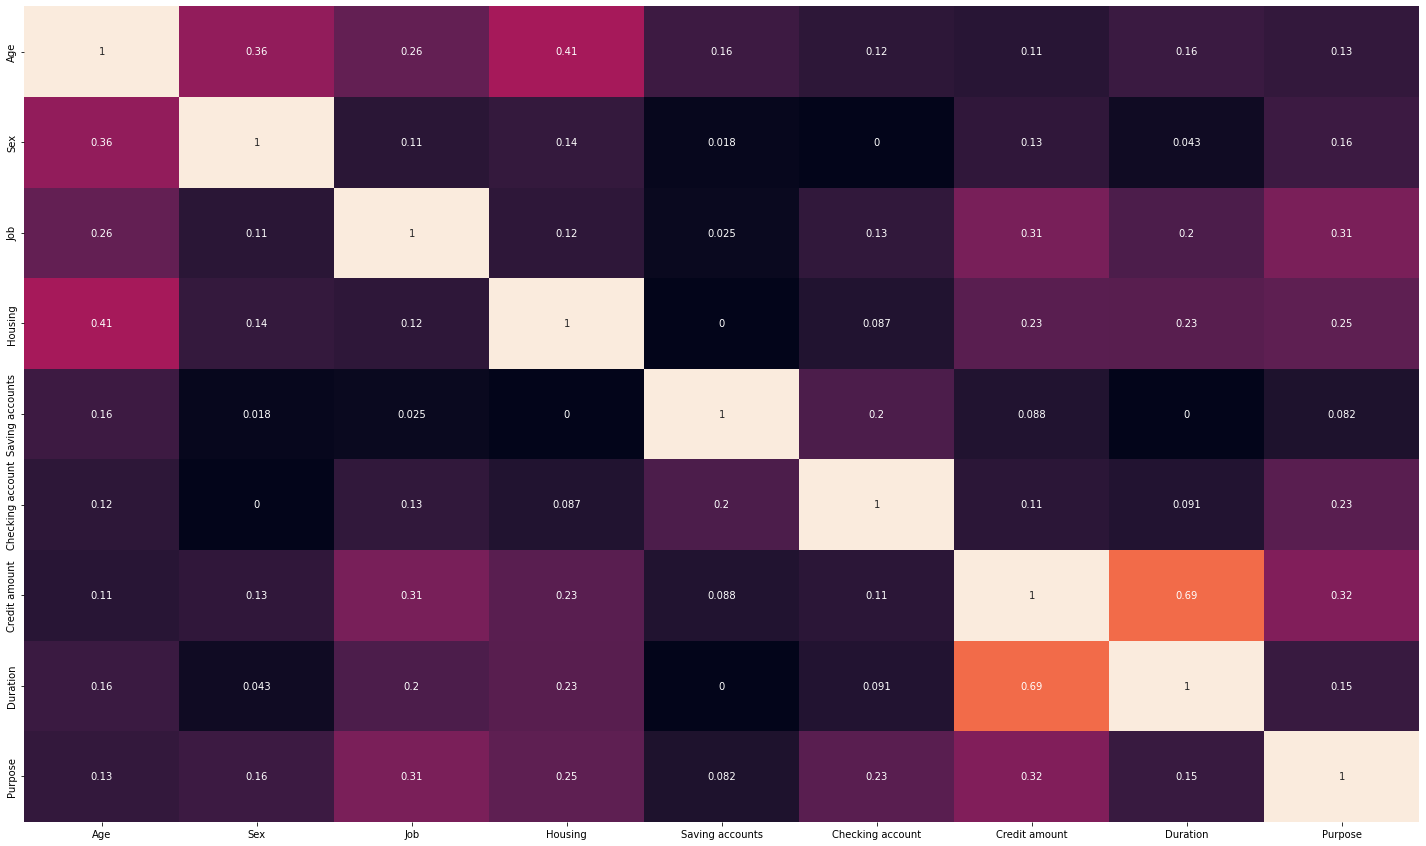

In [19]:
# Feature Correlation
# Setting figure size
fig = plt.figure(figsize = (25, 15))

# Heatmap plotting
sns.heatmap(df2_cluster.phik_matrix(),
            vmin = 0,
            vmax = 1,
            annot = True,
            cbar = False)

### Encoding Data

Categorical data: Sex, Job, Housing, Saving accounts, Checking account, Purpose.

Job has already been encoded

In [20]:
#defining a separate dataset to make it easier to concat later
df_job = df2_cluster[['Job']]

In [21]:
df_bef_enc = df2_cluster[['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']]

In [22]:
df2_cluster['Saving accounts'].value_counts()

little        603
none          183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

**One Hot Encoding tryout**

In [23]:
onehot_enc = OneHotEncoder(sparse=False)

encoded = onehot_enc.fit_transform(df_bef_enc)
encoded = pd.DataFrame(encoded)
encoded

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
996,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
998,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
#Combining with encoded column
encoded_data1 = np.concatenate([encoded, df_job], axis=1)

encoded_data = pd.DataFrame(encoded_data1)
encoded_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


### Scaling Data

This is done because the differences between cases are large in Age, Job, Credit amount, and Duration columns. Therefore, a scaling is needed.

In [28]:
#Defining Numerical Data
df2_num = df2_cluster[['Age', 'Credit amount', 'Duration']]
df2_num.head()

,Age,Credit amount,Duration
0,67,14494431,6
1,22,73786449,48
2,49,25988304,12
3,45,97728918,42
4,53,60383130,24


**Checking Outliers**

In [29]:
def diagnostic_plots(df2_num, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df2_num[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df2_num[variable])
    plt.title('Boxplot')

    plt.show()

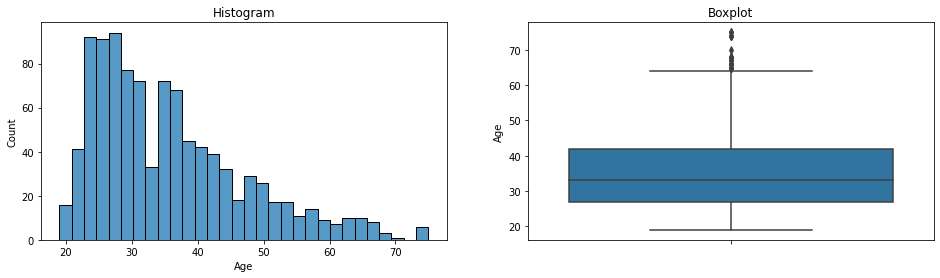

None


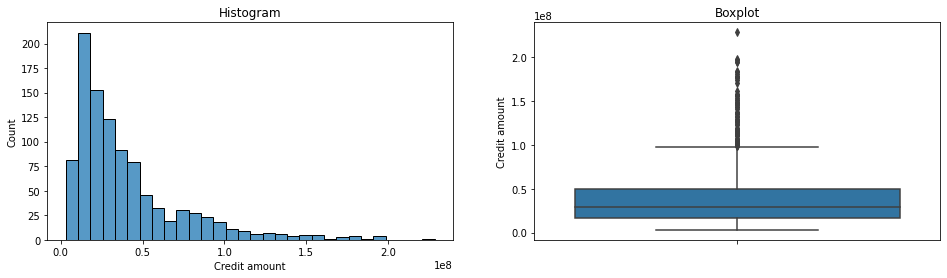

None


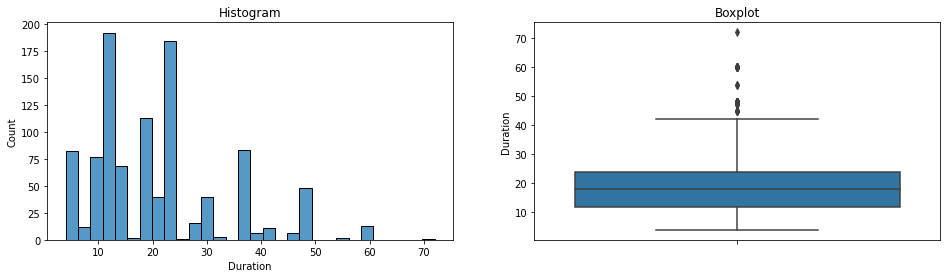

None


In [30]:
print(diagnostic_plots(df2_num, 'Age'))
print(diagnostic_plots(df2_num, 'Credit amount'))
print(diagnostic_plots(df2_num, 'Duration'))

In [31]:
df2_num.skew()

Age              1.020739
Credit amount    1.949628
Duration         1.094184
dtype: float64

In [32]:
#Defining scaler
scaler = MinMaxScaler()
df2_num.head()

,Age,Credit amount,Duration
0,67,14494431,6
1,22,73786449,48
2,49,25988304,12
3,45,97728918,42
4,53,60383130,24


In [33]:
#fitting and transforming scaler
scaled = scaler.fit_transform(df2_num)
scaled_data = pd.DataFrame(scaled)

### Combining Categorical and Numerical Data

In [35]:
df2_fin = pd.DataFrame([])
df2_fin = pd.concat([encoded_data,scaled_data],axis=1)
df2_fin

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,0,1,2
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.857143,0.050567,0.029412
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.053571,0.313690,0.647059
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.535714,0.101574,0.117647
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.464286,0.419941,0.558824
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.607143,0.254209,0.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.214286,0.081765,0.117647
996,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.375000,0.198470,0.382353
997,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.339286,0.030483,0.117647
998,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.071429,0.087763,0.602941


### PCA

In [42]:
#Checking the best reduction
pca = PCA(n_components = 25).fit(df2_fin)
pca.explained_variance_ratio_

array([1.43430280e-01, 1.25795768e-01, 1.17155255e-01, 1.00763289e-01,
       8.90751793e-02, 7.60643122e-02, 6.38483852e-02, 5.94817766e-02,
       3.91498770e-02, 3.60261345e-02, 3.27067940e-02, 2.28075822e-02,
       2.13055250e-02, 1.89452754e-02, 1.52123640e-02, 1.10515029e-02,
       9.35938820e-03, 7.55563369e-03, 4.22145206e-03, 3.47230733e-03,
       2.57191821e-03, 1.05830449e-32, 4.01401022e-33, 2.49990711e-33,
       1.21612521e-33])

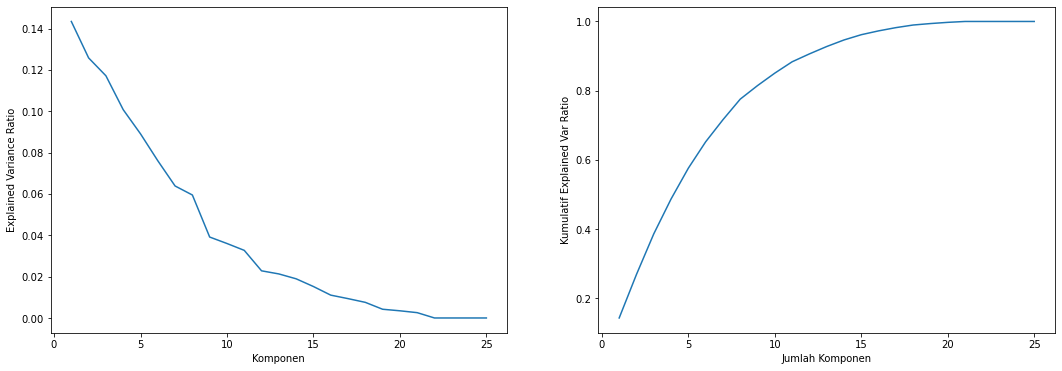

In [43]:
#Elbow method
fig,ax=plt.subplots(ncols=2, figsize=(18, 6))
ax[0].plot(range(1,26), pca.explained_variance_ratio_)
ax[0].set_xlabel('Komponen')
ax[0].set_ylabel('Explained Variance Ratio')

ax[1].plot(range(1,26), np.cumsum(pca.explained_variance_ratio_))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Kumulatif Explained Var Ratio')
plt.show()

In [44]:
#inputting the intended dimension reduction
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df2_fin)

In [45]:
#for visualization
pca2 = PCA(n_components=2)
df_pca2 = pca2.fit_transform(df2_fin)

### Modeling

**K means**

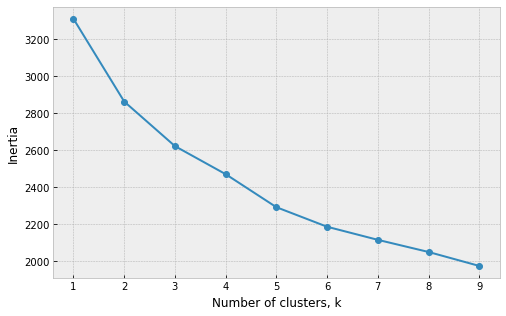

In [46]:
#check the optimal k value
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_pca)
    inertias.append(model.inertia_)

plt.figure(figsize=(8,5))
plt.style.use('bmh')
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [47]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=101).fit(df_pca)
                for k in range(1, 10)]

In [48]:
silhouette_scores = [silhouette_score(df_pca, model.labels_)
                     for model in kmeans_per_k[1:]]

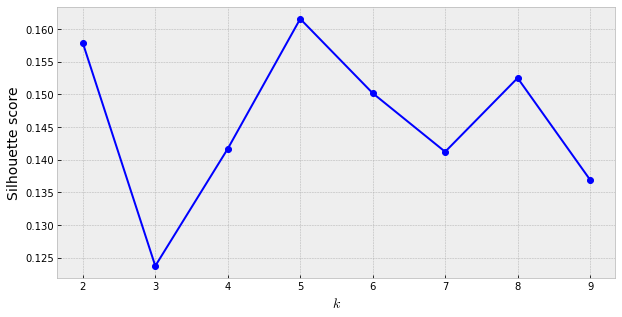

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

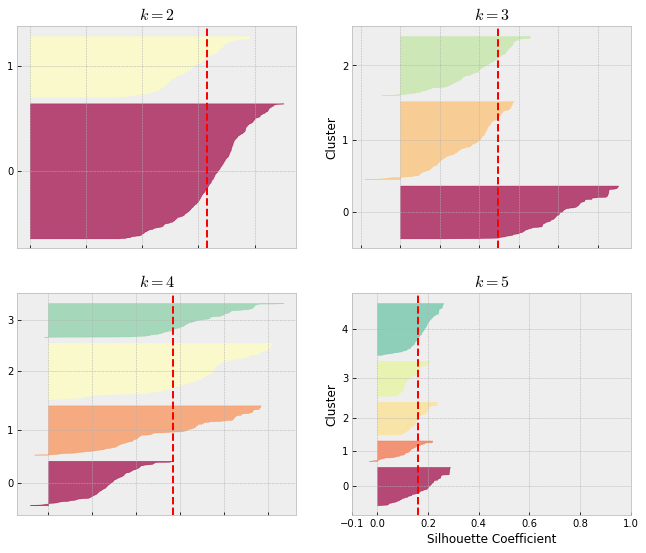

In [50]:
#Using silhouette
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k -1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df_pca, y_pred)

    padding = len(df_pca) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

From the conideration of the elbow graph and silhouette score, it seems that it would be best if I cluster the data into 5 categories.

inertia :  2292.2507446439263


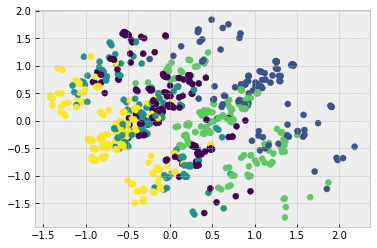

In [51]:
kmeans_lloyd = KMeans(n_clusters=5,algorithm='lloyd',random_state=101)

kmeans_lloyd.fit(df_pca)

print('inertia : ', kmeans_lloyd.inertia_)

labels_kmc_lloyd = kmeans_lloyd.labels_
labels_kmc_lloyd

plt.scatter(df_pca2[:,0],df_pca2[:,1],c=labels_kmc_lloyd,cmap='viridis')

**Spectral Clustering**

In [52]:
#defining and fitting
SP = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=101)
SP.fit(df_pca)

SpectralClustering(affinity='nearest_neighbors', n_clusters=5, random_state=101)

In [53]:
PCA_df = pd.DataFrame(pca.transform(df2_fin))
PCA_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.495342,-0.312673,-0.157781,-0.108000,0.138818,0.419268,1.262288,-0.739767,0.229649,-0.197746,0.108036,-0.064871,0.004935,0.013881,0.100866
1,0.713541,0.058263,0.225230,-1.026831,0.824399,-0.305292,-0.283634,-0.467664,0.169825,-0.085279,-0.048349,-0.191360,0.029873,-0.145316,-0.075964
2,-0.054201,-1.025353,-0.308740,-0.060910,-0.609842,0.025005,-0.471810,0.370639,0.276146,0.257792,0.224291,-0.061611,-0.029763,0.960579,0.024565
3,0.111709,0.774145,-0.958406,0.157526,-0.347859,0.679858,0.341104,0.455004,0.569588,0.592064,-0.476212,-0.201115,-0.066227,-0.321456,0.001141
4,-0.069965,0.803743,-0.922484,0.803453,-0.444052,0.067777,-0.090811,-0.479324,0.404252,0.542673,-0.242692,-0.111843,0.039025,-0.189074,0.050550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.087808,-0.692358,0.397434,-0.460741,-0.675658,-0.301205,-0.160251,0.840604,0.258290,0.022457,-0.291354,-0.140234,-0.142674,-0.135784,-0.047445
996,-0.663868,1.105642,-0.688746,-0.043740,-0.381346,-0.660953,0.318720,-0.367391,-0.248525,-0.165147,0.083599,-0.026912,0.054937,0.053073,-0.009343
997,-0.561304,-0.461018,-0.012265,-0.803225,-0.448228,0.296298,-0.414648,-0.291804,-0.022906,-0.116507,-0.064725,-0.095059,-0.059492,0.015910,0.049280
998,-0.010352,0.468998,-0.834988,-0.173577,-0.165590,0.945092,0.101557,-0.777223,0.384053,0.584857,-0.235812,-0.217414,-0.020898,-0.268725,0.022849


In [54]:
SP.labels_

array([1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 3, 0, 1, 4, 3, 1, 3, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       3, 3, 0, 3, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 3, 0, 1, 0, 1, 1,
       1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1,
       3, 1, 1, 3, 1, 1, 3, 1, 1, 0, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 0, 1, 2, 1, 1, 3, 0, 3, 1, 1, 1, 1, 0, 3, 1, 1, 1, 3, 1, 0,
       1, 1, 1, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 0, 3, 1, 1, 3, 1, 3, 1,
       1, 4, 1, 1, 3, 1, 1, 1, 1, 4, 3, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

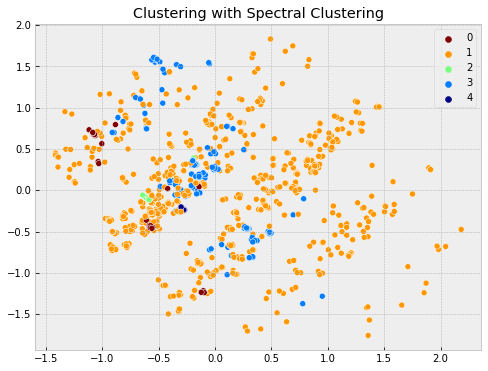

In [55]:
#visualizing spectral clustering
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=df_pca2[:,0], y=df_pca2[:,1], hue=SP.labels_, palette='jet_r')
ax.set_title('Clustering with Spectral Clustering');

**Gaussian Mixture**

In [56]:
#defining and fitting
gmm = GaussianMixture(n_components=5, random_state=101)
gmm.fit(df_pca)

GaussianMixture(n_components=5, random_state=101)

In [57]:
labels_gmm = gmm.predict(df_pca)
labels_gmm

array([1, 2, 4, 1, 1, 4, 4, 3, 4, 3, 2, 2, 2, 1, 2, 2, 4, 1, 2, 4, 4, 1,
       1, 3, 4, 1, 4, 2, 3, 1, 3, 1, 3, 4, 2, 3, 4, 3, 1, 3, 4, 3, 3, 1,
       2, 2, 4, 0, 4, 2, 3, 3, 4, 4, 3, 4, 3, 2, 2, 2, 3, 3, 3, 3, 2, 4,
       2, 3, 4, 2, 2, 4, 1, 2, 1, 1, 1, 3, 4, 3, 2, 4, 0, 2, 1, 2, 2, 3,
       1, 1, 4, 1, 2, 3, 3, 3, 2, 3, 3, 3, 4, 3, 2, 3, 4, 3, 4, 3, 2, 3,
       3, 2, 3, 2, 1, 4, 2, 2, 2, 3, 2, 2, 4, 1, 2, 1, 1, 3, 3, 2, 2, 1,
       4, 4, 2, 2, 4, 3, 3, 2, 3, 2, 1, 1, 2, 3, 2, 2, 1, 4, 4, 4, 3, 2,
       3, 2, 1, 1, 3, 4, 4, 2, 4, 3, 4, 4, 2, 2, 2, 3, 1, 2, 2, 3, 1, 2,
       1, 1, 4, 1, 4, 3, 1, 4, 3, 4, 2, 3, 1, 2, 4, 3, 3, 4, 3, 2, 2, 2,
       3, 3, 4, 1, 4, 1, 4, 1, 4, 3, 1, 4, 4, 2, 1, 3, 4, 2, 1, 3, 1, 2,
       3, 2, 4, 4, 4, 4, 3, 1, 4, 1, 3, 4, 4, 3, 4, 1, 3, 3, 2, 1, 2, 4,
       1, 2, 0, 4, 4, 4, 1, 2, 2, 2, 2, 4, 3, 3, 4, 1, 2, 2, 1, 2, 1, 0,
       4, 3, 4, 2, 1, 4, 4, 2, 3, 3, 1, 4, 2, 1, 2, 4, 4, 4, 3, 4, 3, 2,
       1, 3, 2, 1, 4, 3, 2, 1, 4, 2, 2, 4, 4, 3, 2,

Text(0.5, 1.0, 'Clustering with Gaussian Mixture')

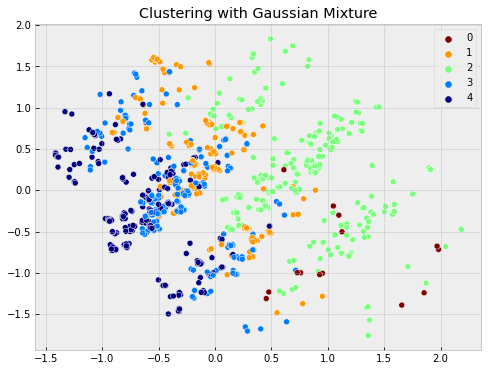

In [58]:
#visualizing gaussian mixture clustering
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=df_pca2[:,0], y=df_pca2[:,1], hue=labels_gmm, palette='jet_r')
ax.set_title('Clustering with Gaussian Mixture')

**Agglomarative Clustering**

In [59]:
agg = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg.fit(df_pca)
agg_labels = model.labels_
agg_labels

array([8, 1, 0, 5, 5, 8, 3, 5, 3, 2, 4, 4, 1, 7, 4, 1, 8, 8, 5, 3, 0, 7,
       7, 2, 8, 7, 3, 4, 2, 7, 2, 7, 2, 8, 1, 2, 5, 3, 3, 2, 3, 2, 2, 7,
       1, 6, 3, 4, 0, 6, 2, 2, 3, 8, 5, 0, 8, 6, 1, 4, 2, 8, 5, 2, 6, 8,
       6, 2, 5, 6, 6, 8, 5, 1, 8, 5, 7, 2, 0, 2, 6, 3, 4, 1, 7, 6, 1, 5,
       7, 7, 3, 7, 6, 8, 2, 2, 6, 2, 2, 8, 0, 2, 6, 2, 8, 2, 3, 2, 1, 2,
       2, 4, 2, 6, 7, 8, 1, 4, 1, 2, 1, 4, 0, 5, 4, 7, 7, 2, 2, 1, 1, 7,
       0, 5, 6, 6, 0, 2, 8, 4, 0, 1, 7, 7, 6, 2, 1, 6, 7, 3, 3, 3, 3, 4,
       2, 4, 7, 7, 2, 8, 3, 6, 3, 5, 0, 3, 1, 1, 4, 2, 7, 6, 1, 2, 7, 6,
       7, 7, 3, 7, 3, 2, 0, 3, 2, 3, 5, 0, 7, 1, 3, 2, 2, 3, 2, 1, 6, 4,
       5, 2, 3, 7, 3, 7, 0, 5, 3, 2, 7, 0, 8, 6, 7, 3, 8, 1, 7, 3, 7, 6,
       2, 4, 3, 8, 0, 3, 2, 5, 3, 5, 3, 0, 3, 2, 3, 7, 0, 2, 6, 7, 1, 3,
       5, 6, 6, 3, 3, 0, 7, 4, 1, 1, 1, 3, 8, 8, 3, 5, 6, 6, 7, 1, 5, 6,
       0, 2, 8, 6, 7, 8, 8, 4, 5, 2, 7, 3, 6, 7, 6, 3, 0, 3, 8, 8, 2, 1,
       7, 5, 1, 7, 3, 5, 5, 5, 8, 1, 4, 0, 3, 2, 0,

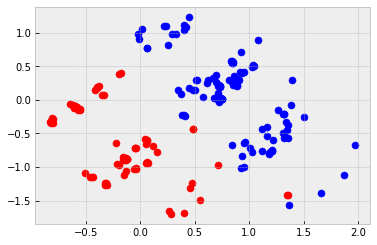

In [60]:
plt.scatter(df_pca[agg_labels==0, 0], df_pca[agg_labels==0, 1], s=50, marker='o', color='red')
plt.scatter(df_pca[agg_labels==1, 0], df_pca[agg_labels==1, 1], s=50, marker='o', color='blue')

### Compare Model Performance

In [61]:
compare = pd.DataFrame({'Method' : ['K-Means', 'Spectral', 'Gaussian Mixture', 'Agglomerative'],
                  'Silhouete Score' : [silhouette_score(df_pca, kmeans_lloyd.labels_), silhouette_score(df_pca, SP.labels_), silhouette_score(df_pca, labels_gmm), silhouette_score(df_pca, agg_labels)]})
compare

,Method,Silhouete Score
0,K-Means,0.161526
1,Spectral,-0.113477
2,Gaussian Mixture,0.139687
3,Agglomerative,0.152649


Based on the comparative model performance, it can be seen that the worst performing model is Spectral Clustering, while the best performing model which has the biggest silhouette score is K-Means. Therefore, for the next exploratory data analysis, we are going to use the clustering that is done with the K-Means model.

### EDA

In [62]:
#Creating new column for the clusters
df2_cluster['cluster'] = kmeans_lloyd.labels_
df2_cluster.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,cluster
0,67,male,2,own,none,little,14494431,6,radio/TV,0
1,22,female,2,own,little,moderate,73786449,48,radio/TV,3
2,49,male,1,own,little,none,25988304,12,education,4
3,45,male,2,free,little,little,97728918,42,furniture/equipment,0
4,53,male,2,free,little,little,60383130,24,car,0


In [63]:
#Checking how many data in each cluster
df2_cluster['cluster'].value_counts()

4    291
0    215
3    196
2    183
1    115
Name: cluster, dtype: int64

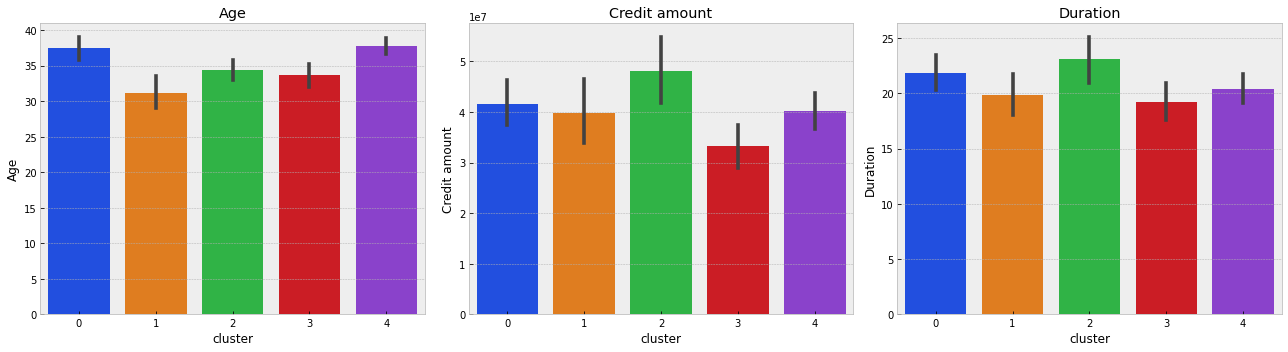

In [64]:
#Visualizing clusters
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.barplot(x = 'cluster', y = 'Age', data=df2_cluster, palette="bright")
plt.title('Age')

plt.subplot(1,3,2)
sns.barplot(x = 'cluster', y = 'Credit amount', data=df2_cluster, palette="bright")
plt.title('Credit amount')

plt.subplot(1,3,3)
sns.barplot(x = 'cluster', y = 'Duration', data=df2_cluster, palette="bright")
plt.title('Duration')

plt.tight_layout()

plt.show()

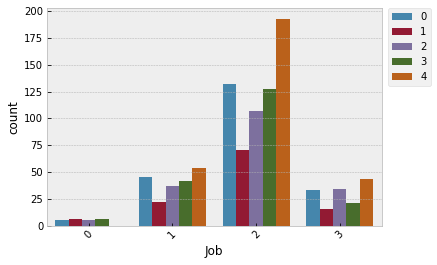

In [65]:
#Visualizing job per cluster
sns.countplot(x='Job',data=df2_cluster, hue= 'cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)
plt.show()

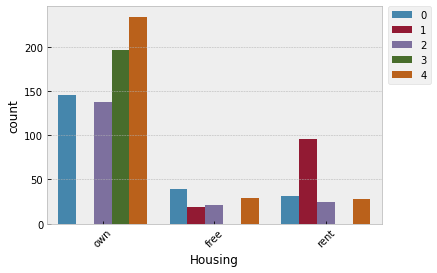

In [66]:
#Visualizing housing per cluster
sns.countplot(x='Housing',data=df2_cluster, hue= 'cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)
plt.show()

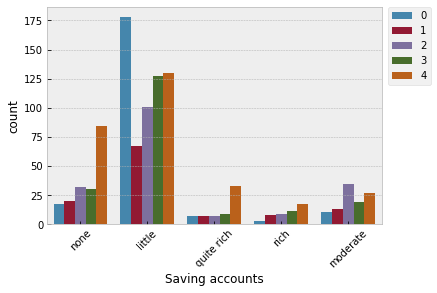

In [67]:
#Viisulalizing saving accounts per cluster
sns.countplot(x='Saving accounts',data=df2_cluster, hue= 'cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)
plt.show()

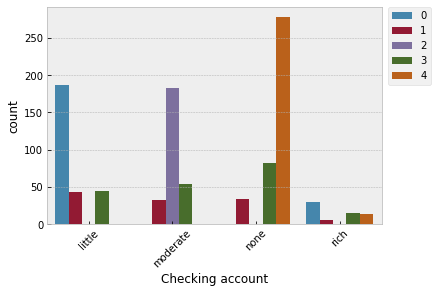

In [68]:
#Visualizing checking account per cluster
sns.countplot(x='Checking account',data=df2_cluster, hue= 'cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)
plt.show()

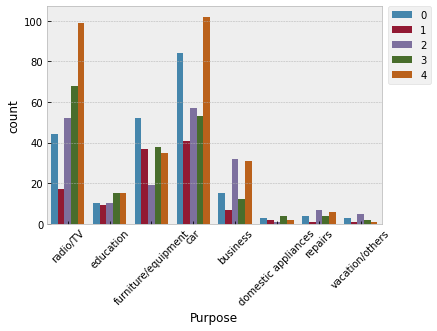

In [69]:
#Visualizing purpose per cluster
sns.countplot(x='Purpose',data=df2_cluster, hue= 'cluster')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation=45)
plt.show()

**description**

From the graphs above, I can conclude that there are some striking qualities that might categorize some of the clusters. 

0 – Mid Credit	| Little Savings	| Little Checking

1 – Mid Credit	| Mostly Rent Housing

2 – High Credit	| Moderate Checking

3 – Low Credit

4 – Mid Credit	| No Checking

We need a further analysis to draw a conclusion from the clusters.

**Cluster 0**

In [71]:
cluster0 = df2_cluster[df2_cluster['cluster'] == 0]
cluster0.mean().round()

Age                    37.0
Job                     2.0
Credit amount    41607930.0
Duration               22.0
cluster                 0.0
dtype: float64

In [72]:
cluster0.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,215.0,3.742791e+01,1.229783e+01,20.0,27.0,36.0,44.5,75.0
Job,215.0,1.897674e+00,6.688980e-01,0.0,2.0,2.0,2.0,3.0
Credit amount,215.0,4.160793e+07,3.330828e+07,4190862.0,17550784.5,31952223.0,51226468.5,196610943.0
Duration,215.0,2.184186e+01,1.212178e+01,6.0,12.0,20.0,30.0,60.0
cluster,215.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0


In [96]:
cluster0['Housing'].value_counts()

own     145
free     39
rent     31
Name: Housing, dtype: int64

In [73]:
cluster0['Saving accounts'].value_counts()

little        178
none           17
moderate       10
quite rich      7
rich            3
Name: Saving accounts, dtype: int64

In [74]:
cluster0['Checking account'].value_counts()

little    186
rich       29
Name: Checking account, dtype: int64

In [75]:
cluster0['Purpose'].value_counts()

car                    84
furniture/equipment    52
radio/TV               44
business               15
education              10
repairs                 4
domestic appliances     3
vacation/others         3
Name: Purpose, dtype: int64

**Cluster 1**

In [76]:
cluster1 = df2_cluster[df2_cluster['cluster'] == 1]
cluster1.mean().round()

Age                    31.0
Job                     2.0
Credit amount    39865480.0
Duration               20.0
cluster                 1.0
dtype: float64

In [77]:
cluster1.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,115.0,3.121739e+01,1.220856e+01,19.0,23.0,26.0,37.0,74.0
Job,115.0,1.843478e+00,7.205177e-01,0.0,2.0,2.0,2.0,3.0
Credit amount,115.0,3.986548e+07,3.445728e+07,4860408.0,16850241.0,27538179.0,47277387.0,183282018.0
Duration,115.0,1.987826e+01,1.011092e+01,4.0,12.0,18.0,24.0,60.0
cluster,115.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0


In [78]:
cluster1['Saving accounts'].value_counts()

little        67
none          20
moderate      13
rich           8
quite rich     7
Name: Saving accounts, dtype: int64

In [79]:
cluster1['Checking account'].value_counts()

little      43
none        34
moderate    32
rich         6
Name: Checking account, dtype: int64

In [80]:
cluster1['Purpose'].value_counts()

car                    41
furniture/equipment    37
radio/TV               17
education               9
business                7
domestic appliances     2
vacation/others         1
repairs                 1
Name: Purpose, dtype: int64

**Cluster 2**

In [81]:
cluster2 = df2_cluster[df2_cluster['cluster'] == 2]
cluster2.mean().round()

Age                    34.0
Job                     2.0
Credit amount    48084474.0
Duration               23.0
cluster                 2.0
dtype: float64

In [82]:
cluster2.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,183.0,3.444809e+01,1.023548e+01,20.0,27.0,32.0,38.0,70.0
Job,183.0,1.928962e+00,7.035097e-01,0.0,2.0,2.0,2.0,3.0
Credit amount,183.0,4.808447e+07,4.331745e+07,3422124.0,17482590.0,31245480.0,68045712.0,197702055.0
Duration,183.0,2.307104e+01,1.396701e+01,6.0,12.0,18.0,30.0,72.0
cluster,183.0,2.000000e+00,0.000000e+00,2.0,2.0,2.0,2.0,2.0


In [83]:
cluster2['Saving accounts'].value_counts()

little        101
moderate       34
none           32
rich            9
quite rich      7
Name: Saving accounts, dtype: int64

In [84]:
cluster2['Checking account'].value_counts()

moderate    183
Name: Checking account, dtype: int64

In [85]:
cluster2['Purpose'].value_counts()

car                    57
radio/TV               52
business               32
furniture/equipment    19
education              10
repairs                 7
vacation/others         5
domestic appliances     1
Name: Purpose, dtype: int64

**Cluster 3**

In [86]:
cluster3 = df2_cluster[df2_cluster['cluster'] == 3]
cluster3.mean().round()

Age                    34.0
Job                     2.0
Credit amount    33273412.0
Duration               19.0
cluster                 3.0
dtype: float64

In [87]:
cluster3['Saving accounts'].value_counts()

little        127
none           30
moderate       19
rich           11
quite rich      9
Name: Saving accounts, dtype: int64

In [88]:
cluster3['Checking account'].value_counts()

none        82
moderate    54
little      45
rich        15
Name: Checking account, dtype: int64

In [89]:
cluster3['Purpose'].value_counts()

radio/TV               68
car                    53
furniture/equipment    38
education              15
business               12
domestic appliances     4
repairs                 4
vacation/others         2
Name: Purpose, dtype: int64

**Cluster 4**

In [90]:
cluster4 = df2_cluster[df2_cluster['cluster'] == 4]
cluster4.mean().round()

Age                    38.0
Job                     2.0
Credit amount    40237269.0
Duration               20.0
cluster                 4.0
dtype: float64

In [91]:
cluster4.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,291.0,3.782131e+01,1.018530e+01,20.0,30.5,36.0,44.0,74.0
Job,291.0,1.965636e+00,5.802983e-01,1.0,2.0,2.0,2.0,3.0
Credit amount,291.0,4.023727e+07,3.242280e+07,5281974.0,18300924.0,29088054.0,47816743.5,194081547.0
Duration,291.0,2.039519e+01,1.156772e+01,4.0,12.0,18.0,24.0,60.0
cluster,291.0,4.000000e+00,0.000000e+00,4.0,4.0,4.0,4.0,4.0


In [97]:
cluster4['Job'].value_counts()

2    193
1     54
3     44
Name: Job, dtype: int64

In [98]:
cluster4['Housing'].value_counts()

own     234
free     29
rent     28
Name: Housing, dtype: int64

In [92]:
cluster4['Saving accounts'].value_counts()

little        130
none           84
quite rich     33
moderate       27
rich           17
Name: Saving accounts, dtype: int64

In [93]:
cluster4['Checking account'].value_counts()

none    278
rich     13
Name: Checking account, dtype: int64

In [94]:
cluster4['Purpose'].value_counts()

car                    102
radio/TV                99
furniture/equipment     35
business                31
education               15
repairs                  6
domestic appliances      2
vacation/others          1
Name: Purpose, dtype: int64

From further inspection, we are focusing on the characteristics that might separate one group from the other, and it is known from each group that:

0 – Mid Credit	| Little to no savings	| Little to rich Checking	| Purpose for car, furniture/equipment, and radio/TV

1 – Mid Credit	| Little to no savings	| Little to no Checking	| Purpose for car	| Mostly rent housing

2 – High Credit	| Little to moderate savings	| Moderate Checking	| Purpose for car and radio/TV

3 – Low Credit	| Little to no savings	| No to moderate Checking	| Purpopse for radio/TV and car

4 – Mid Credit	| Little to no savings	| No Checking	| Purpopse for car


### Conclusion

1. People in cluster 0 could be considered as low risk though the bank should check further towards the exact amounts that is going to be lended and the amount of financial capability that the prospect debitor has.

2. People in cluster 1 is considered as a high risk prospect debitor due to the mid credit amount that they have, and yet they have little to no amount both in their saving and checking account. Added on top of that, they are mostly still renting and borrowing money for a car.

3. People in cluster 2 could be considered as low risk since although they have high credit amount, they have little to moderate savings and moderate checking amount, and the purpose is for radio/TV or a car. Though it has to be inspected further how much the radio or car might cost.

4. People in cluster 3 is deemed low risk since they have low credit though they have little to no savings. Their Checking account is either none or moderate, and the purpose is either for radio/TV and car.

5. People in cluster 4 could be considered as high risk since they have mid credit, and yet they have little to no savings, no checking account, and the purpose is for car.

6. Several variables are not distinctive enough to differentiate one cluster from the other in this case and might better represent the user characteristic as a whole such as the Job category and purpose as most of the users are skilled at their job and most of the people are taking loans for a car. Only in this case the purpose helps us decide which one is low risk and which one is high risk.

7. Two of the variables that could help explain the data better doesn't contain enough information despite the explanation in the sheets, those variables are credit amount and duration. In the description, credit amount is only explained to be in IDR and doesn't explain whether it's the current amount that the user owes to the bank and is trying to pay off or is it the amount that the user wants to borrow. Whereas duration is only explained to be in months, but we don't know whether that is the duration in which the user is going to pay off the loan, or whether it's the duration of how long the user has been a user to the bank. If the data to this were to be provided, it might help separate between groups.

**Limitations**

Due to the limited time, there isn't much exploration that can be done towards the data. However, further improvement is possible by applying different preprocessing methods, changing the number of clusters, or perhaps even changing the whole method in finding which users has high risk.

In [100]:
#Assigning each cluster to their final group
Risk=[]


for c in range(len(df2_cluster)):
  if df2_cluster['cluster'][c] in [0,2,3]:
    group = 'Low'
  else:
    group = 'High'
  Risk.append(group)

In [102]:
df2_cluster['Risk'] = Risk
df2_cluster.drop(['cluster'], axis=1, inplace=True)
df2_cluster.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,none,little,14494431,6,radio/TV,Low
1,22,female,2,own,little,moderate,73786449,48,radio/TV,Low
2,49,male,1,own,little,none,25988304,12,education,High
3,45,male,2,free,little,little,97728918,42,furniture/equipment,Low
4,53,male,2,free,little,little,60383130,24,car,Low


In [103]:
df2_cluster.to_excel('df2_final.xlsx')